In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import os
import sys
import json 
import re
from decomp import UDSCorpus


font = {'family' : 'Times New Roman',
        'weight' : 'regular',
        'size'   : 22}

matplotlib.rc('font', **font)




miso_path = "/home/hltcoe/estengel/miso_research"
sys.path.insert(0, miso_path)

PLOT_DIR = "/home/hltcoe/estengel/syntax-semantics-2021/figures/"



In [2]:
transformer_data_path = "/exp/estengel/miso_res/transformer_fix/decomp_base_tuned/data.json"
bilstm_data_path = "/exp/estengel/miso_res/new_models/decomp-lstm-base/data.json"
unilstm_data_path = "/exp/estengel/miso_res/analysis/decomp_lstm_unidirectional/data.json"


paths = {"tfmr": "/exp/estengel/miso_res/new_models/decomp-transformer-best/data.json",
        "bilstm": "/exp/estengel/miso_res/new_models/decomp-lstm-base/data.json",
        "unilstm":"/exp/estengel/miso_res/analysis/decomp_lstm_unidirectional/data.json",
        "tfmr + en": "/exp/estengel/miso_res/experimental/transformer/decomp_transformer_encoder_best/data.json",
        "bilstm + en": "/exp/estengel/miso_res/new_interface/decomp_lstm_encoder/data.json"}


data = {k: None for k in paths.keys()}

for key, path in paths.items():
    with open(path) as f1:
        key_data = json.load(f1)
        data[key] = key_data
        

    
# build ontology
attribute_ontology = list(sorted(data['tfmr'].keys()))
    

In [3]:
# need to re-munge output 
# current output: {subspace: {true: {nodes},
#                              pred: {nodes}}
# what we want:
# {sentence: {node_id: {subspace: (true, pred)}}}

def get_sent_id(whole_id):
    sent_id = "-".join(whole_id.split("-")[0:3])
    sent_idx = int(whole_id.split("-")[2])
    return sent_id, sent_idx

def get_node_id(whole_id):
    node_id = "-".join(whole_id.split("-")[3:])
    node_idx = int(whole_id.split("-")[-1])
    return node_id, node_idx

out_dict = {k:{} for k in data.keys()}
# for model, model_data in zip(["bilstm", "unilstm", "tfmr"], [bilstm_data, unilstm_data, tfmr_data]):
for model, model_data in data.items(): 
    lil_dict = out_dict[model]
    # loop once to collect all sentence ids and node ids 
    for subspace_id, subspace_dict in model_data.items():
        for whole_id in subspace_dict["true_val_with_node_ids"]:
            sent_id, sent_idx = get_sent_id(whole_id)
            if sent_idx not in lil_dict.keys():
                lil_dict[sent_idx] = {}
            node_id, node_idx = get_node_id(whole_id)
            if node_idx not in lil_dict[sent_idx].keys():
                lil_dict[sent_idx][node_idx] = {}
                
            true_node_value = subspace_dict["true_val_with_node_ids"][whole_id]
            pred_node_value = subspace_dict["pred_val_with_node_ids"][whole_id]
            lil_dict[sent_idx][node_idx][subspace_id] = (true_node_value, pred_node_value)
            
    out_dict[model] = lil_dict
            

In [4]:
corpus = UDSCorpus(split="dev")
LONG_LIMIT = 0
# here only consider long sentences
# get avg sentence len
all_lens = []
for sid, graph in corpus.items():
    all_lens.append(len(re.split("\s+", graph.sentence)))
avg_len = sum(all_lens)/len(all_lens)
print(f"avg len {avg_len}")


def get_midpoint(sent_idx):
    sent_id = f"ewt-dev-{sent_idx}"
    graph = corpus[sent_id]
    sent = re.split("\s+", graph.sentence) 
    if len(sent) < LONG_LIMIT:
        # mark for skipping
        return None 
#     midpoint = len(sent)/2
    # percentage done instead
    return len(sent)
    
midpoint_dict = {k: {} for k in data.keys()} 
# for each sentence, get midpoint 
for model in midpoint_dict.keys():
    for sent_idx in out_dict[model].keys():
        midpoint = get_midpoint(sent_idx)
        if midpoint is None:
            # mark for skipping 
            continue
        midpoint_dict[model][sent_idx] = midpoint


avg len 12.561438561438562


In [5]:
# group pred and true values into buckets by distance from midpoint 
# bucket_dict: {distance: [subspace: (true, pred)...]}
from collections import defaultdict
bucket_dict = {k: defaultdict(lambda: defaultdict(lambda: defaultdict(list))) for k in data.keys()}
binsize = 10

for model, model_data in out_dict.items():
    for sent_idx, sent_data in model_data.items():
        try:
            midpoint = midpoint_dict[model][sent_idx]
        except KeyError:
            # skip sentences less than 13
            continue
        for node_idx, node_data in sent_data.items():
            # normalize nodes to be 0-indexed 
#             node_idx = node_idx - 1
#             distance = int(midpoint - node_idx) 
            # use percentage of sentence done 
            true_distance = (node_idx/midpoint)*100
            # round distance 
            distance = (true_distance // binsize) * 10
            
            true_data = np.ones(len(node_data)) 
            pred_data = np.ones(len(node_data)) 
            
            for subspace, (tv, pv) in node_data.items():
                bucket_dict[model][distance][subspace]["true"].append(tv)
                bucket_dict[model][distance][subspace]["pred"].append(pv)


print(bucket_dict['tfmr'][0]["factuality-factual"]["true"][0:10])
print(bucket_dict['tfmr'][0]["factuality-factual"]["pred"][0:10])

            


[1.033, 1.2321, 1.1329, -1.2252, -1.1617, 1.133, 1.0583, 1.0583, 1.0583, 0.0263]
[0.8035169243812561, 0.7691439986228943, 1.1487634181976318, -0.2604743540287018, -0.19235529005527496, 0.8980245590209961, 0.9662803411483765, 0.9998868703842163, 1.0190861225128174, -0.36719292402267456]


In [6]:
from scipy.stats import pearsonr 

# compute pearson for each bucket 
pearson_data = defaultdict(lambda: defaultdict(list))
for model_name, model_bucket_dict in bucket_dict.items():
    for distance, distance_dict in model_bucket_dict.items():
        for subspace, subspace_dict in distance_dict.items():
            true_vals = np.array(subspace_dict["true"])
            pred_vals = np.array(subspace_dict["pred"])
            if len(true_vals) > 10:
                assert(len(true_vals) == len(pred_vals))
            else:
                continue
            rho, p_val = pearsonr(true_vals, pred_vals)
            if np.isnan(rho):
                continue 
#             if rho < 0:
#                 # skip for now
#                 continue  
            if p_val < 0.05:
                pearson_data[model_name][distance].append(rho)

for model, model_pearson_data in pearson_data.items():
    for distance, distance_rhos in model_pearson_data.items():
        avg_rho = np.mean(distance_rhos)
        model_pearson_data[distance] = avg_rho
    pearson_data[model] = model_pearson_data
#         pearson_data[model][distance] = avg_rho 
    
print(pearson_data.keys())
print(pearson_data['tfmr'])



dict_keys(['tfmr', 'bilstm', 'unilstm', 'tfmr + en', 'bilstm + en'])
defaultdict(<class 'list'>, {50.0: 0.647786483953221, 40.0: 0.6228015924224233, 80.0: 0.6208832244881002, 20.0: 0.6083725087324194, 10.0: 0.6321461818779313, 30.0: 0.6308276772708394, 0.0: 0.5880463039470407, 90.0: 0.6383124180326436, 70.0: 0.6235393770362053, 60.0: 0.6111672327120073, 100.0: 0.8632118256771107})


dict_items([(50.0, 0.5817491266211167), (40.0, 0.5684637913754029), (80.0, 0.5514289868070785), (20.0, 0.5227810565274913), (10.0, 0.5759031421525284), (30.0, 0.6332072204356902), (0.0, 0.5470193531930694), (90.0, 0.5662429550136671), (70.0, 0.5614718039650556), (60.0, 0.5698470713160205), (100.0, 0.8263957741320296)])
dict_items([(50.0, 0.5580786973072701), (40.0, 0.5515411665331337), (80.0, 0.5323432261018686), (20.0, 0.54358873123549), (10.0, 0.5719073059332974), (30.0, 0.575054140493014), (0.0, 0.5634727837334246), (90.0, 0.5612529043463624), (70.0, 0.5459658747270804), (60.0, 0.5485486459860962), (100.0, 0.8433026654506339)])
dict_items([(50.0, 0.647786483953221), (40.0, 0.6228015924224233), (80.0, 0.6208832244881002), (20.0, 0.6083725087324194), (10.0, 0.6321461818779313), (30.0, 0.6308276772708394), (0.0, 0.5880463039470407), (90.0, 0.6383124180326436), (70.0, 0.6235393770362053), (60.0, 0.6111672327120073), (100.0, 0.8632118256771107)])


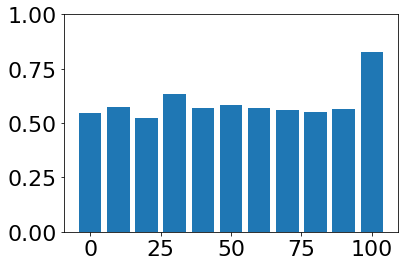

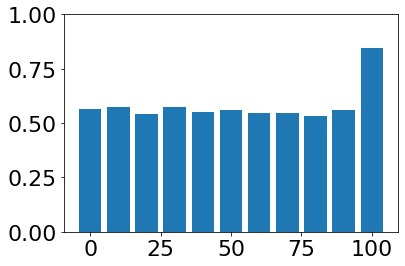

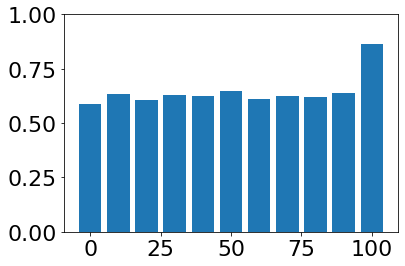

In [7]:
# plot separately 
def plot(pearson_dict):
    plt.figure()
    # sort by distance 
    print(pearson_dict.items())
    distances, pearsons = zip(*sorted(pearson_dict.items(), key = lambda x : x[0]))
    plt.bar(distances, pearsons, width=8)
    plt.ylim(0, 1.0)

    
plot(pearson_data['unilstm'])
plot(pearson_data['bilstm'])
plot(pearson_data['tfmr'])


(0.0, 1.0)

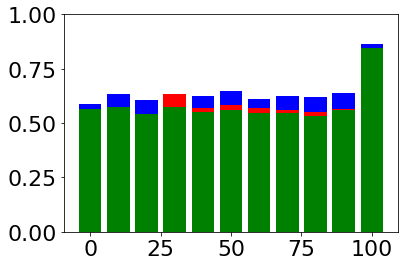

In [8]:
to_plot_xs = []
to_plot_ys_bilstm = []
to_plot_ys_unilstm = []
to_plot_ys_tfmr = []


for distance in pearson_data['bilstm'].keys():
    if distance in pearson_data['tfmr'].keys() \
        and distance in pearson_data["unilstm"].keys():
        to_plot_xs.append(distance)
        to_plot_ys_bilstm.append(pearson_data['bilstm'][distance])
        to_plot_ys_unilstm.append(pearson_data['unilstm'][distance])
        to_plot_ys_tfmr.append(pearson_data['tfmr'][distance])

        

plt.figure()

plt.bar(to_plot_xs, to_plot_ys_tfmr, width=8, color="b")
plt.bar(to_plot_xs, to_plot_ys_unilstm, width=8, color="r")
plt.bar(to_plot_xs, to_plot_ys_bilstm, width=8, color='g')

plt.ylim(0,1)


In [9]:
# plot delta 

name_dict = {"BILSTM": "BiLSTM",
            "UNILSTM": "LSTM",
            "TFMR": "TFMR"}
def plot_delta(ax, key1, key2):
    blue = "#67a9cf"
    red = "#ef8a62"
    
    to_plot_xs = []
    to_plot_ys_deltas = []
    to_plot_colors = []
    for distance in pearson_data[key1].keys():
        if distance in pearson_data[key2].keys():
            to_plot_xs.append(distance)
            delta = pearson_data[key2][distance] - pearson_data[key1][distance]
            to_plot_ys_deltas.append(delta)
            if delta > 0:
                to_plot_colors.append(blue) 
            else:
                to_plot_colors.append(red)
                
    ax.set_ylim(-0.03, 0.10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([0, 50, 100])
    ax.set_xticklabels(labels = ["0%", "50%", "100%"])
    ax.set_yticks([-0.03, 0.0, 0.03, 0.06, 0.09])
#     ax.spines['bottom'].set_visible(False)
#     ax.spines['left'].set_visible(False)
    ax.set_title(f"{name_dict[key2.upper()]} - {name_dict[key1.upper()]}")
    ax.bar(to_plot_xs, to_plot_ys_deltas, width=8, color = to_plot_colors)

#     plt.ylim(0,0.124)

# plot_delta( "bilstm", "tfmr")

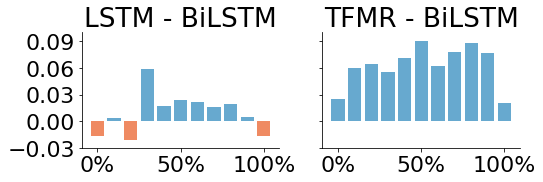

In [11]:

fig, ax = plt.subplots(nrows=1, ncols=2, sharey = True, sharex = False, figsize=(8,3))
plot_delta(ax[0], "bilstm","unilstm")
plot_delta(ax[1], "bilstm","tfmr")
plt.tight_layout() 
plt.savefig(os.path.join(PLOT_DIR, "lstm_tfmr_pearson_percentiles.pdf"))

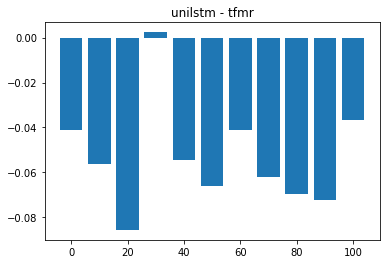

In [57]:
plot_delta("tfmr","unilstm")

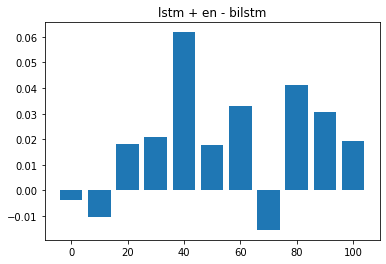

In [58]:
plot_delta("bilstm","lstm + en")

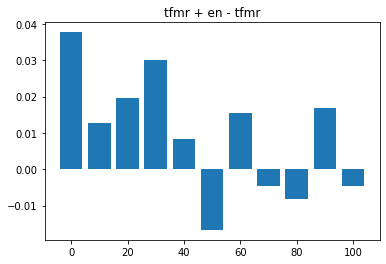

In [59]:
plot_delta("tfmr","tfmr + en")